In [1]:
#pip install nltk 
#pip install spacy
#pip install requests beautifulsoup4
# pip install textblob
# pip install wordcloud


Verarbeite: https://www.bundestagswahl-bw.de/wahlprogramm-spd
Verarbeite: https://www.bundestagswahl-bw.de/wahlprogramm-bsw
Verarbeite: https://www.bundestagswahl-bw.de/wahlprogramm-gruene
Verarbeite: https://www.bundestagswahl-bw.de/wahlprogramm-afd
Verarbeite: https://www.bundestagswahl-bw.de/wahlprogramm-die-linke
Verarbeite: https://www.bundestagswahl-bw.de/wahlprogramm-fdp


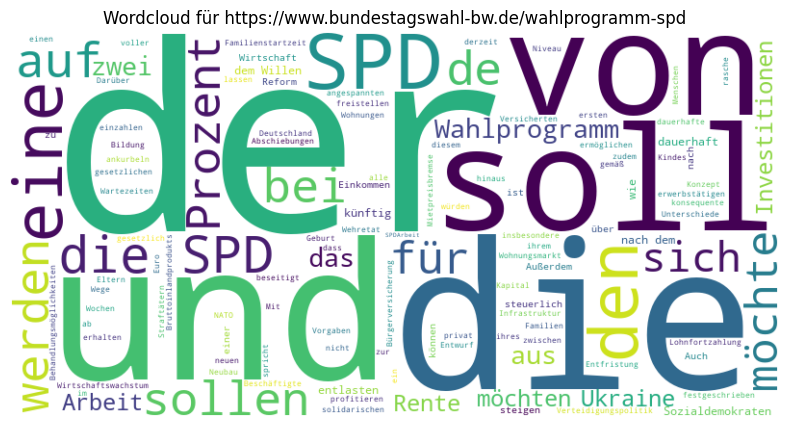

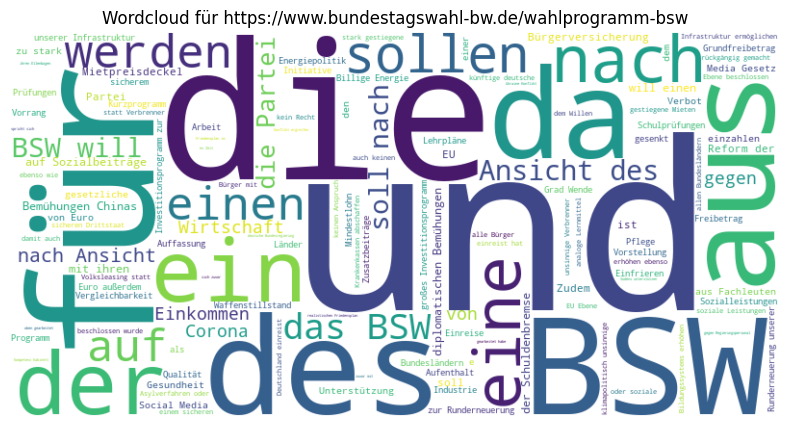

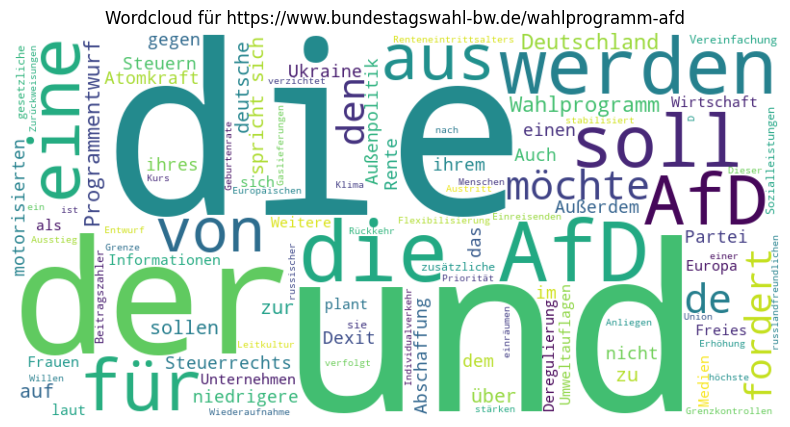

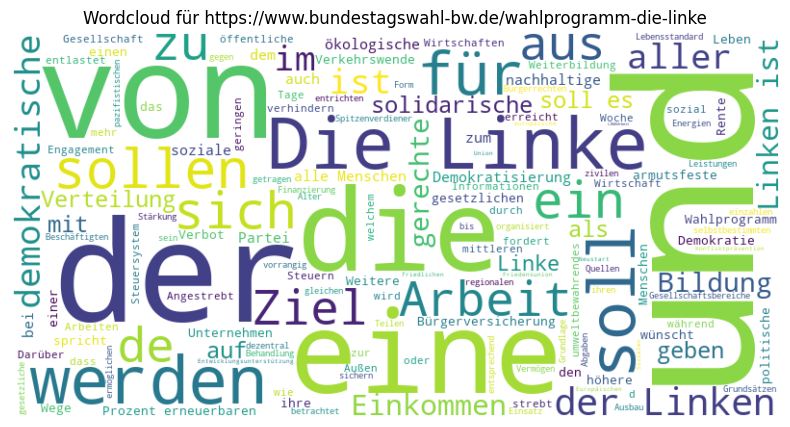

In [52]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Falls nötig: NLTK-Resourcen herunterladen
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

class WahlprogrammeScraper:
    def __init__(self, base_url):
        self.base_url = base_url
        self.session = requests.Session()
        self.stop_words = set(stopwords.words('german'))  # Deutsche Stopwörter
        self.lemmatizer = WordNetLemmatizer()
        self.common_phrases = ["Impressum", "Datenschutz", "Kontakt", "Nutzungsbedingungen", "Cookie-Richtlinie"]

    def get_html(self, url):
        """Holt den HTML-Quelltext einer gegebenen URL."""
        response = self.session.get(url, headers={"User-Agent": "Mozilla/5.0"})
        if response.status_code == 200:
            return response.text
        else:
            print(f"Fehler beim Abruf der Seite: {url}")
            return None

    def extract_party_links(self):
        """Generiert die Links zu den Wahlprogrammen der Parteien."""
        parties = ["spd", "bsw", "gruene", "afd", "die-linke", "fdp"]  
        links = [f"{self.base_url}/wahlprogramm-{party}" for party in parties]
        return links

    def extract_text_from_page(self, url):
        """Extrahiert den relevanten Text von einer Partei-Wahlprogrammseite zwischen 'Übersicht' und 'Weitere Informationen'."""
        html = self.get_html(url)
        if not html:
            return ""
        
        soup = BeautifulSoup(html, 'html.parser')
        return self.extract_relevant_text(soup)
    
    def extract_relevant_text(self, soup):
        """Extrahiert den Text zwischen 'Übersicht' und 'Weitere Informationen'."""
        main_content = soup.find("main", class_="inhalt col-md-9")
        if not main_content:
            return "Kein relevanter Abschnitt gefunden."
        
        start_section = main_content.find("h2", string=re.compile("Übersicht", re.IGNORECASE))
        end_section = main_content.find("h2", string=re.compile("Weitere Informationen", re.IGNORECASE))
        
        if start_section and end_section:
            content = []
            #collecting = False
            seen_sentences = set()  # Verhindert doppelte Sätze
            
            for elem in start_section.find_all_next():
                if elem == end_section:
                    break
                if elem.name in ["h2", "p", "div", "span"]:  # Nur relevante Textcontainer berücksichtigen
                    text = elem.get_text(strip=True)
                    sentences = text.split('.')  # Satzweises Splitten
                    for sentence in sentences:
                        clean_sentence = sentence.strip()
                        if clean_sentence and clean_sentence not in seen_sentences:  # Verhindert Duplikate
                            content.append(clean_sentence)
                            seen_sentences.add(clean_sentence)
            
            return ". ".join(content)
        
        return "Kein relevanter Abschnitt gefunden."

    def scrape_all_programs(self):
        """Sammelt Wahlprogramme aller Parteien von der Hauptseite."""
        party_links = self.extract_party_links()
        programmes = {}
        
        for link in party_links:
            print(f"Verarbeite: {link}")
            text = self.extract_text_from_page(link)
            
            if text and text != "Kein relevanter Abschnitt gefunden.":
                programmes[link] = text  # Alle Duplikate werden direkt in `extract_relevant_text` entfernt
        
        return programmes

    def generate_wordclouds(self, programmes):
        """Erstellt eine Wordcloud für jede Partei."""
        for party, content in programmes.items():
            if content and content != "Kein relevanter Abschnitt gefunden.":
                wordcloud = WordCloud(width=800, height=400, background_color="white").generate(content)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation="bilinear")
                plt.axis("off")
                plt.title(f"Wordcloud für {party}")
                plt.show()

if __name__ == "__main__":
    url = "https://www.bundestagswahl-bw.de"
    scraper = WahlprogrammeScraper(url)
    programmes = scraper.scrape_all_programs()
    
    # Wordclouds generieren
    scraper.generate_wordclouds(programmes)


In [8]:
''' es muss noch Alles Text außerhalb der Wahlthemen rausgenommen werden und sämtliches Artikel etc. rausgefiltert werden.'''

'Welche Positionen vertritt die FDP 2025 in verschiedenen Politikfeldern wie z.B. Wirtschaft, Arbeit & Soziales, Migration & Integration, Umwelt & Klima oder der Außen- und Sicherheitspolitik?\nDarüber entscheiden die Liberalen aller Voraussicht nach am 9. Februar 2025 – dann will die Partei in Potsdam ihr Wahlprogramm beschließen und ihren Spitzenkandidaten nominieren. Das wird Christian Lindner sein.\nzum Wahlprogramm auf der Webseite der FDP\nBundestagswahlprogramm (Download als PDF)\nKurzwahlprogramm(Download als PDF): In anderen Sprachen (Download als PDF):Spanisch, Italienisch, Französisch, Ukrainisch, Türkisch, Polnisch, Hebräisch, Arabisch oder Kurdisch.\nDie wesentlichen Punkte, mit denen die FDP die in der Präambel ihres Programmentwurfs skizzierte „Veränderung zum Besseren“ erreichen will, haben wir an dieser Stelle für Sie zusammengefasst. Eine ausführliche Analyse des Wahlprogramms folgt.\nMehr Geld für Pädagoginnen und Pädagogen\nIm Vorschulalter soll es Sprachtests geben

In [51]:
# Wahlprogramm der SPD aus dem Dictionary abrufen
spd_programm = programmes.get("https://www.bundestagswahl-bw.de/wahlprogramm-spd", "Kein Wahlprogramm gefunden")

if spd_programm != "Kein Wahlprogramm gefunden":
    # Den Text nach Abschnitten aufteilen
    sections = spd_programm.split(". ")
    print("=== Wahlprogramm der SPD ===\n")
    for i, section in enumerate(sections, start=1):
        if section.strip():  # Überspringe leere Abschnitte
            print(f"\n{section.strip()}\n")
else:
    print("Kein Wahlprogramm gefunden.")

=== Wahlprogramm der SPD ===


Wahlprogramm SPDArbeit & WirtschaftSteuernRenteFamilienGesundheitWohnenMigrationVerteidigungspolitik & Ukraine


Wahlprogramm SPD


Arbeit & Wirtschaft


Steuern


Rente


Familien


Gesundheit


Wohnen


Migration


Verteidigungspolitik & Ukraine


Arbeit & WirtschaftDeutschlandfonds und Reform der SchuldenbremseMit Investitionen in Wirtschaft, Bildung und Infrastruktur möchten die Sozialdemokraten das Wirtschaftswachstum ankurbeln


Realisiert werden, soll dieses Vorhaben über einen „Deutschlandfonds“, der staatliches und privates Kapital bündelt und zunächst 100 Milliarden Euro umfassen soll


Zentral ist für die SPD eine Reform und Abschwächung der Schuldenbremse


Auf diesem Wege möchte sie zusätzlichen politischen Handlungsspielraum für Investitionen schaffen


Außerdem sollen Unternehmen, die in Deutschland Investitionen tätigen künftig von einem besonderen „Made-in-Germany-Bonus“ profitieren


Konkret bedeutet dies, dass zehn Prozent der getätigte

In [49]:
for party, content in programmes.items():
    print(f"{party}: {len(content.split())} Wörter")


https://www.bundestagswahl-bw.de/wahlprogramm-spd: 697 Wörter
https://www.bundestagswahl-bw.de/wahlprogramm-bsw: 1201 Wörter
https://www.bundestagswahl-bw.de/wahlprogramm-afd: 641 Wörter
https://www.bundestagswahl-bw.de/wahlprogramm-die-linke: 968 Wörter


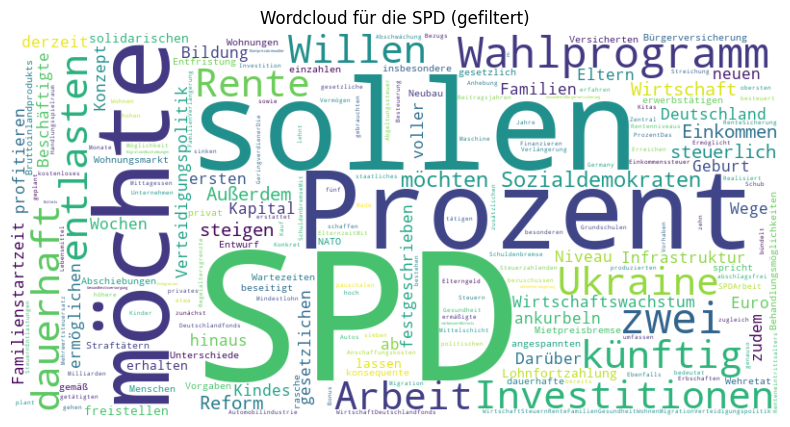

In [55]:
# Deutsche Stopwörter laden
german_stopwords = set(stopwords.words('german'))

# Funktion zum Entfernen von Stopwörtern
def remove_stopwords(text):
    words = word_tokenize(text, language='german')  # Tokenize den Text
    filtered_text = " ".join([word for word in words if word.lower() not in german_stopwords])
    return filtered_text

# Gefilterte Wahlprogramme speichern
filtered_programmes = {party: remove_stopwords(text) for party, text in programmes.items()}

# Wordcloud für die SPD erzeugen
spd_text = filtered_programmes.get("https://www.bundestagswahl-bw.de/wahlprogramm-spd", "Kein Wahlprogramm gefunden")

if spd_text != "Kein Wahlprogramm gefunden":
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(spd_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Wordcloud für die SPD (gefiltert)")
    plt.show()
else:
    print("Kein Wahlprogramm für die SPD gefunden.")